# Figures for Comprehensive Exam Paper
#### David W. Barker

## Purpose: 
The purpose of this notebook is to put all of the code to create the figures for my comps in one place. My other notebooks have been getting extremely messy. This will focus on the second half of my paper after the exotic models. I may add the exotic models into this notebook later, but as I am a bit pressed for time right now, I'll stick to the figures I have yet to make.

In [ ]:
# Boilerplate

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import pylinex
import py21cmsig
import importlib
import corner
import lochness
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from importlib import reload
from pylinex import RepeatExpander, ShapedExpander, NullExpander,\
    PadExpander, CompiledQuantity, Extractor,  CalculatedQuantity
import spiceypy as spice
from datetime import datetime
import enlighten

# color map for all the plots:
cmap = "inferno"

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map 64 bit
ULSA_direction_raw_64 = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/100.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=64,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw_64[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw_64[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(hp.nside2npix(64))
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw_64[0].data)
for i,data in enumerate(ULSA_direction_raw_64[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction_64 = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map_64 = ULSA_direction_64    # default galaxy map


# ULSA map 32 bit
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
f = h5py.File("/home/dbarker7752/21_cm_group/foreground_array_minCMB","r")
foreground_array_minCMB = f["foreground_array"]


# radiometer noise
sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))
# Noise parameters
dnu = 1e6
dt = 1000*3600 # first number is the number of hours of integration time

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

# frequencies = np.arange(6,50,0.1)
frequencies = np.arange(6,50,0.25)
## RMS ##
#simulation_test = py21cmsig.simulation_run_raw(frequencies,files[0],foreground_array_minCMB,test_times1,dnu,dt,omR0,omM0,omK0,omL0,omB0) # needs to be run to get RMS, that's its only purpose

rms_mean = 0.05
rms_std = 0.009


# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction,7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]

# creates the fiducial Lambda CDM signal
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

# This creates the sky maps that are properly rotated and normalized
beams = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams[n][nu] = normalized_beam

f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams","r")
beams = f["normalized_beams"]

beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

save_path = "/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/" 

/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.111 s.


100%|██████████| 221/221 [00:03<00:00, 60.03it/s]


### ULSA Galaxy Example and ULSA Galaxy Rotated Example

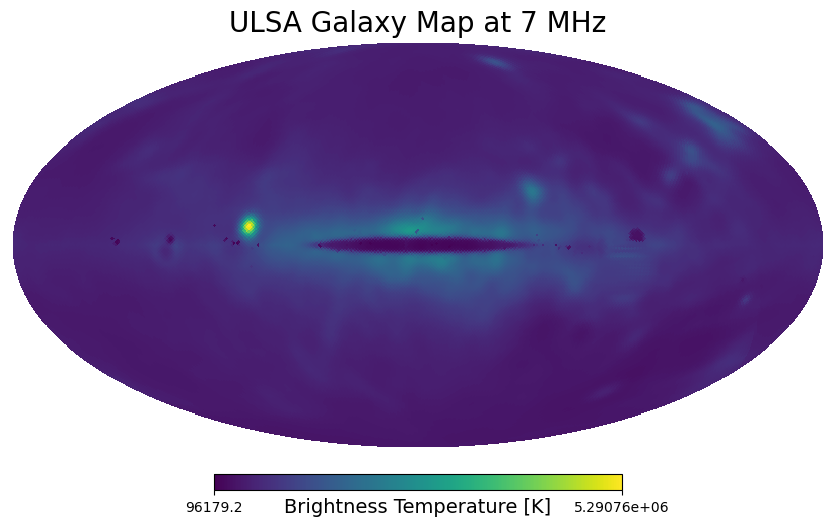

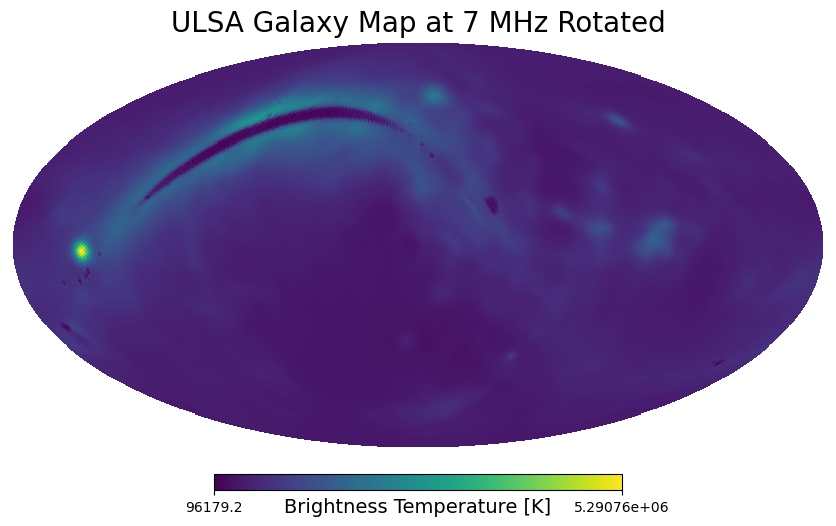

In [ ]:
# ULSA Galaxy Example and ULSA Galaxy Rotated Example

# Standard unrotated galaxy
hp.mollview(galaxy_map_64[7],unit="Brightness Temperature [K]",cmap= cmap)
plt.title("ULSA Galaxy Map at 7 MHz" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Standard")


# ## next few lines create and save the rotated galaxy to save time when loading this up again.
# # galaxy creation part
# # Now we rotate it into a frame consistent with a LuSEE-Night observation window.
# rotated_64_ULSA = lochness.LOCHNESS(spice_kernels,test_times1,location,galaxy_map=galaxy_map_64).lunar_frame_galaxy_maps[0]
# rotated_64_ULSA[np.where(rotated_64_ULSA<0.0)] = 0
# # HDF5 part
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","w")
# hdf5.create_dataset("rotated_sky_maps",data=rotated_64_ULSA)
# hdf5.close()
# ## End of galaxy map creation and hdf5 saving code

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

hp.mollview(rotated_64_ULSA[7],min=96179.2,max=5290760,cmap=cmap,unit="Brightness Temperature [K]")
plt.title("ULSA Galaxy Map at 7 MHz Rotated" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Rotated")

## Five Region Model with Rotated Galaxy
- We'll use the rotated galaxy for examples from here on out since that's the actual foreground we used as our base model.

100%|██████████| 10/10 [00:00<00:00, 4809.43it/s]


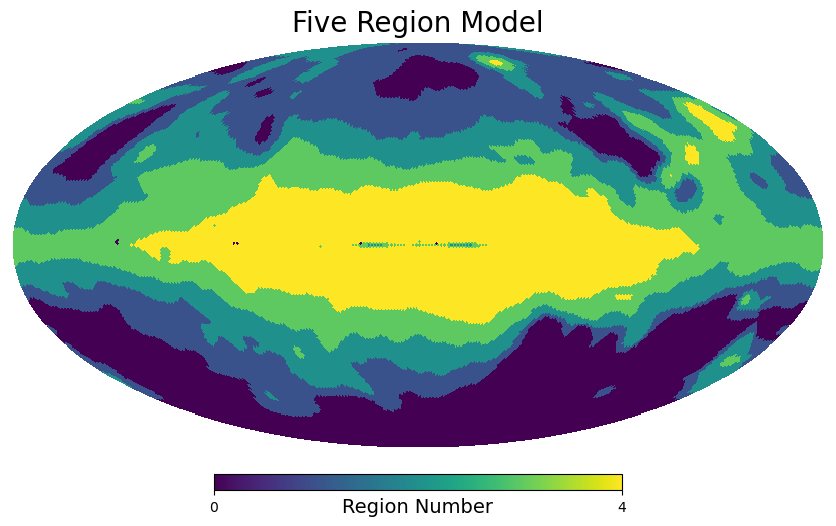

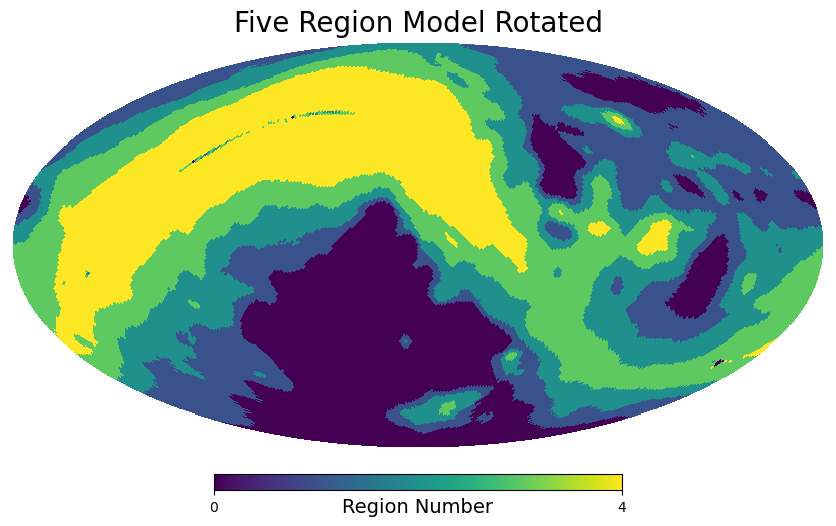

In [58]:
# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction_64,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]
hp.mollview(best_foreground_model[11],unit = "Region Number")
plt.title("Five Region Model", fontsize=20)
plt.savefig(save_path+"five_region_model")

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,rotated_64_ULSA,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]
hp.mollview(best_foreground_model_rotated[11],unit = "Region Number")
plt.title("Five Region Model Rotated", fontsize=20)
plt.savefig(save_path+"five_region_model_rotated")

## Varied Foreground Example

In [67]:
# Simulation and Training Set for a single LST
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")


# data = simulation_test_beam[0]
# one_sigma_rms = rms_std
# training_set = varied_regolith_training_set_raw
# training_set_parameters = varied_regolith_training_set_raw_params
# signal_extraction_return = signal_extraction(data,rms_mean,rms_std,training_set,training_set_parameters,N=10000,sigma_tolerance=3,iteration_limit=10)


## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

copy_rotated_ULSA = rotated_64_ULSA
copy_rotated_ULSA[7][region_indices_rotated[0]] += foreground_run_set[5][0][0][4]
copy_rotated_ULSA[7][region_indices_rotated[1]] += foreground_run_set[5][0][1][4]
copy_rotated_ULSA[7][region_indices_rotated[2]] += foreground_run_set[5][0][2][4]
copy_rotated_ULSA[7][region_indices_rotated[3]] += foreground_run_set[5][0][3][4]
copy_rotated_ULSA[7][region_indices_rotated[4]] += foreground_run_set[5][0][4][4]

copy_rotated_ULSA[40][region_indices_rotated[0]] += foreground_run_set[5][100][0][136]
copy_rotated_ULSA[40][region_indices_rotated[1]] += foreground_run_set[5][100][1][136]
copy_rotated_ULSA[40][region_indices_rotated[2]] += foreground_run_set[5][100][2][136]
copy_rotated_ULSA[40][region_indices_rotated[3]] += foreground_run_set[5][100][3][136]
copy_rotated_ULSA[40][region_indices_rotated[4]] += foreground_run_set[5][100][4][136]

100%|██████████| 2/2 [00:00<00:00, 3483.64it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 125.93it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 239.15it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 15505.74it/s]

[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


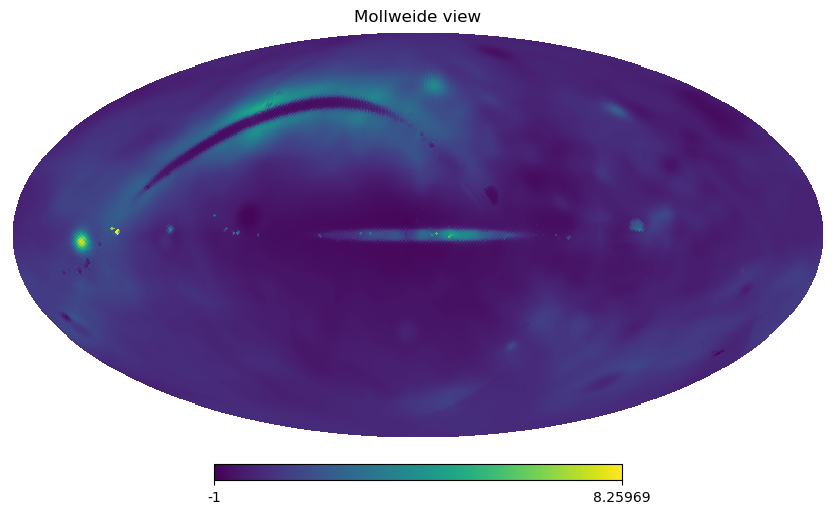

In [69]:
hp.mollview((copy_rotated_ULSA[7]-ULSA_direction_64[7])/ULSA_direction_64[7])

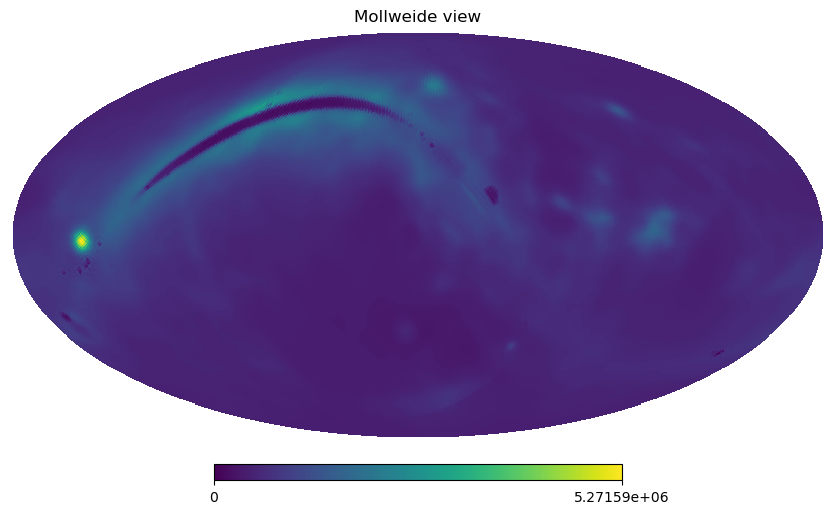

In [70]:
hp.mollview(copy_rotated_ULSA[7])